# Prediction de la demande d'electricite avec LSTM

## Importation des packages necessaires

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from itertools import product
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

## Creation du Frame

In [2]:
import glob
import os

all_files = glob.glob("../../power supply/archive/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files))

## Affichage de l'entete du frame

In [3]:
df

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2018/01/01 00:30:00,6912.25,91.86,TRADE
1,NSW1,2018/01/01 01:00:00,6745.63,88.83,TRADE
2,NSW1,2018/01/01 01:30:00,6466.06,73.62,TRADE
3,NSW1,2018/01/01 02:00:00,6279.80,71.49,TRADE
4,NSW1,2018/01/01 02:30:00,6177.31,69.27,TRADE
...,...,...,...,...,...
7771,NSW1,2023/06/27 23:40:00,8536.43,116.99,TRADE
7772,NSW1,2023/06/27 23:45:00,8527.02,89.00,TRADE
7773,NSW1,2023/06/27 23:50:00,8489.29,88.88,TRADE
7774,NSW1,2023/06/27 23:55:00,8358.07,61.74,TRADE


## Supprimer les colonnes inutiles

In [4]:
df.drop(['REGION', 'PERIODTYPE'], axis =1, inplace=True)
df.head()

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2018/01/01 00:30:00,6912.25,91.86
1,2018/01/01 01:00:00,6745.63,88.83
2,2018/01/01 01:30:00,6466.06,73.62
3,2018/01/01 02:00:00,6279.80,71.49
4,2018/01/01 02:30:00,6177.31,69.27


## Renommer les colonnes

In [5]:
#df = df.rename({"old-name-col1":"new-name-col1", "old-name-col2":"new-name-col2",},axis=1)
df = df.rename({"TOTALDEMAND":"demande", "RRP":"prix", "SETTLEMENTDATE":"date",},axis=1)

## Definir la colonne index

In [6]:
df = df.set_index("date")
df.head()

,demande,prix
date,,
2018/01/01 00:30:00,6912.25,91.86
2018/01/01 01:00:00,6745.63,88.83
2018/01/01 01:30:00,6466.06,73.62
2018/01/01 02:00:00,6279.80,71.49
2018/01/01 02:30:00,6177.31,69.27


## Mettre la date (l'index) sous un format exploitable

In [7]:
df.index = pd.to_datetime(df.index, format="mixed")
df.head()

,demande,prix
date,,
2018-01-01 00:30:00,6912.25,91.86
2018-01-01 01:00:00,6745.63,88.83
2018-01-01 01:30:00,6466.06,73.62
2018-01-01 02:00:00,6279.80,71.49
2018-01-01 02:30:00,6177.31,69.27


## Classer le frame par date croissante

In [8]:
df.sort_values(by=['date'], inplace=True)
df.head()

,demande,prix
date,,
2018-01-01 00:30:00,6912.25,91.86
2018-01-01 01:00:00,6745.63,88.83
2018-01-01 01:30:00,6466.06,73.62
2018-01-01 02:00:00,6279.80,71.49
2018-01-01 02:30:00,6177.31,69.27


## Afficher le frame

<Axes: xlabel='date'>

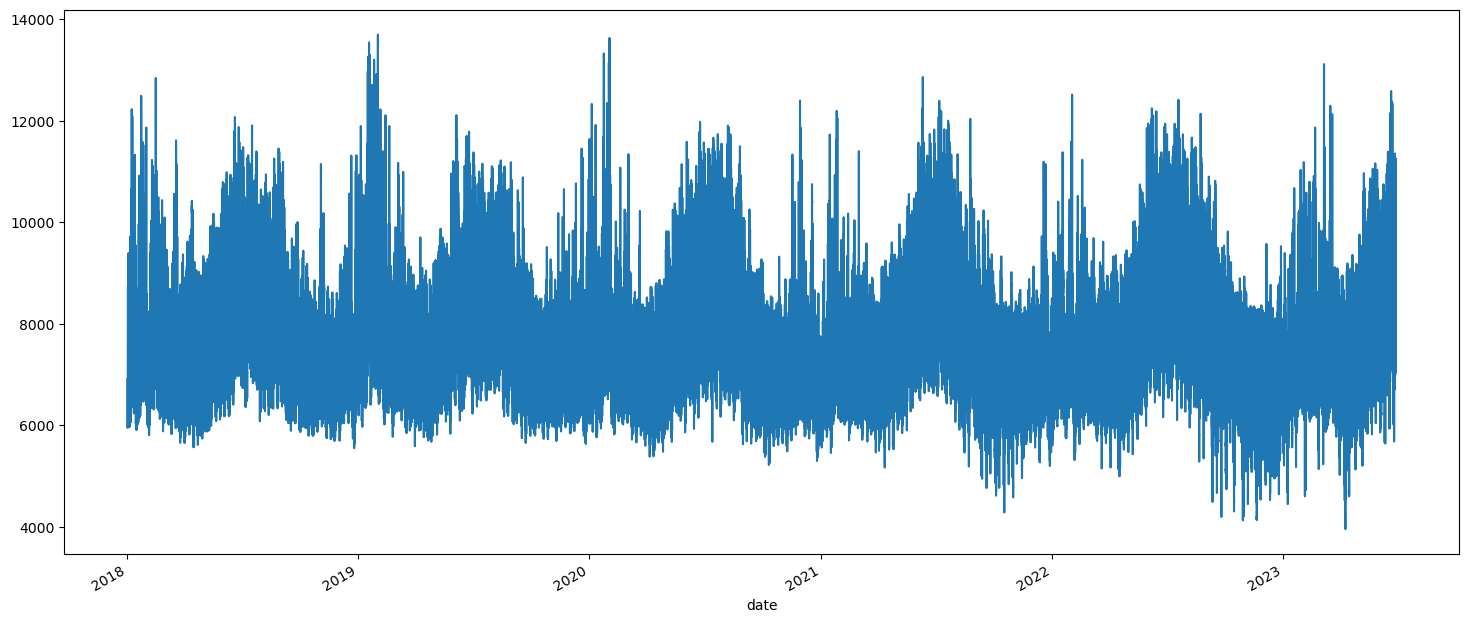

In [9]:
df.demande.plot(figsize=[18,8])

<Axes: ylabel='Frequency'>

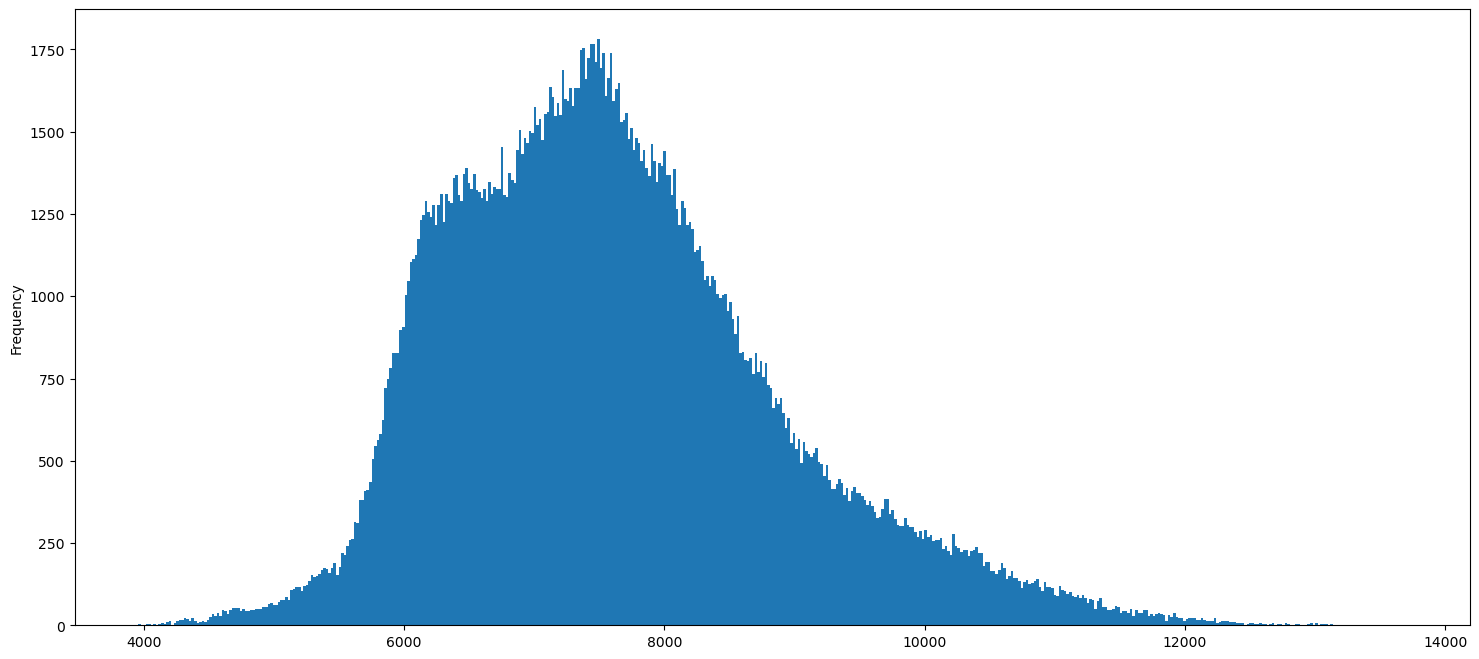

In [10]:
df.demande.plot(kind="hist", bins=500, figsize=[18,8])

<Axes: xlabel='date'>

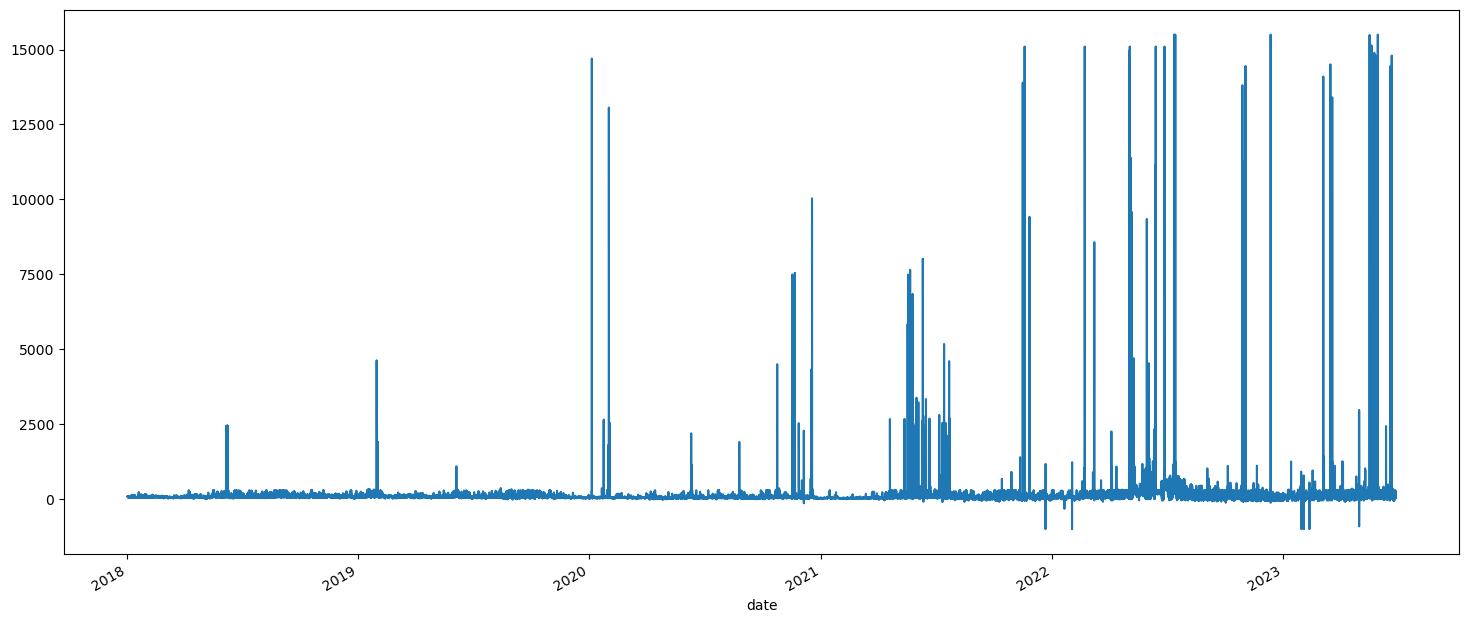

In [11]:
df.prix.plot(figsize=[18,8])

<Axes: ylabel='Frequency'>

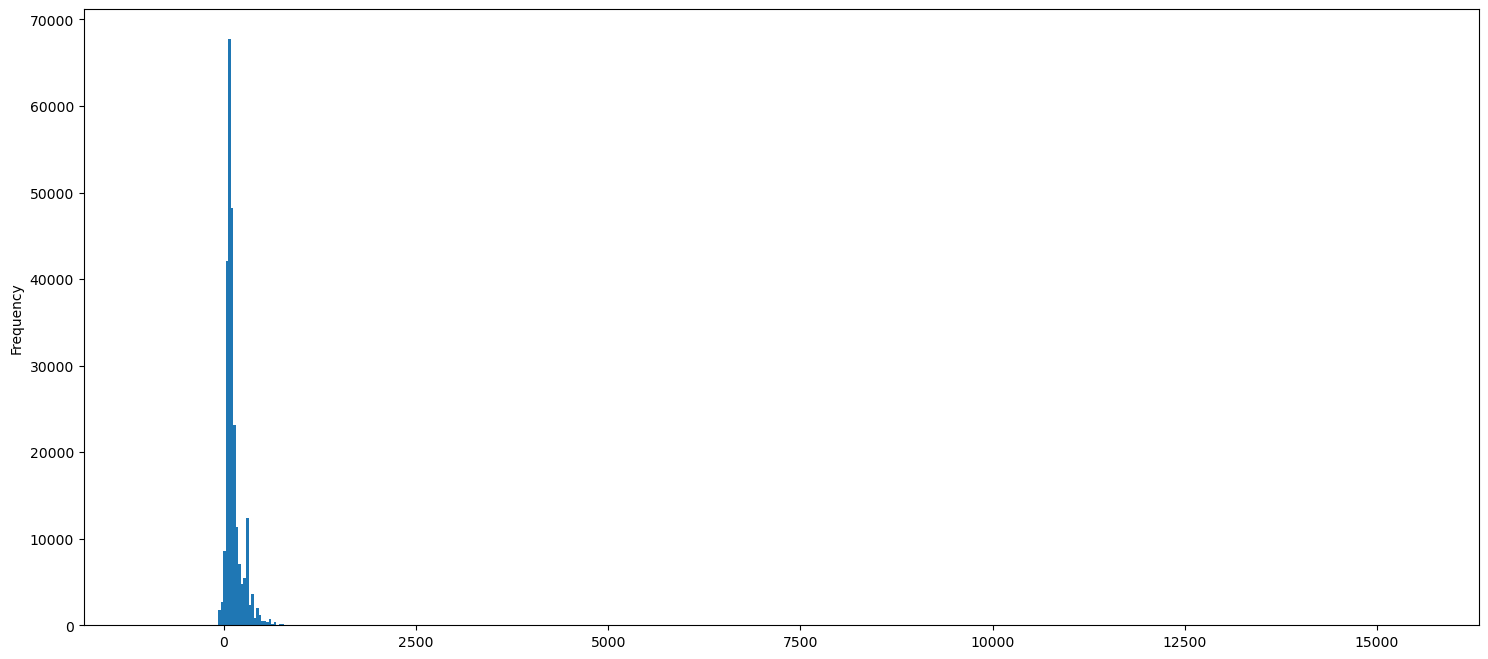

In [12]:
df.prix.plot(kind="hist", bins=500, figsize=[18,8])

## Afficher les donnees sous certaines conditions

In [13]:
df[df["demande"] > 10000]

,demande,prix
date,,
2018-01-06 15:00:00,10157.24,86.70
2018-01-06 15:30:00,10338.83,89.49
2018-01-06 16:00:00,10509.42,94.77
2018-01-06 16:30:00,10578.21,100.03
2018-01-06 17:00:00,10658.87,94.58
...,...,...
2023-06-27 20:35:00,10191.01,135.18
2023-06-27 20:40:00,10175.35,140.02
2023-06-27 20:45:00,10140.97,138.00


In [14]:
df[(df.index > "2022-10-10") & (df.index <= "2022-10-17")]

,demande,prix
date,,
2022-10-10 00:05:00,7032.45,299.99
2022-10-10 00:10:00,6996.44,299.99
2022-10-10 00:15:00,6979.87,299.99
2022-10-10 00:20:00,6906.34,299.16
2022-10-10 00:25:00,6913.04,298.99
...,...,...
2022-10-16 23:40:00,6702.20,163.00
2022-10-16 23:45:00,6699.04,163.00
2022-10-16 23:50:00,6702.53,160.73


## Creation des Features

In [15]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import date
import holidays

In [16]:
def set_features(df):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Ajout des caractéristiques temporelles
    df["minuteofhour"] = df.index.minute  # Minute de l'heure
    df['quarter'] = df.index.quarter  # Trimestre de l'année
    df['Time'] = (df.index.hour * 60 + df.index.minute) / 60  # Heure et minute converties en fraction d'heure
    df["hourofday"] = df.index.hour  # Heure de la journée
    df["dayofweek"] = df.index.dayofweek  # Jour de la semaine (lundi=0, dimanche=6)
    df['weekday'] = df.index.weekday  # Jour de la semaine (lundi=0, dimanche=6)
    df["dayofmonth"] = df.index.day  # Jour du mois
    df["dayofyear"] = df.index.dayofyear  # Jour de l'année
    df["weekofyear"] = df.index.isocalendar().week  # Semaine de l'année
    df["weekofyear"] = df["weekofyear"].astype(int)  # Conversion en entier
    df["month"] = df.index.month  # Mois de l'année
    df["year"] = df.index.year  # Année
    return df

In [17]:
df = set_features(df)
df

,demande,prix,minuteofhour,quarter,Time,hourofday,dayofweek,weekday,dayofmonth,dayofyear,weekofyear,month,year
date,,,,,,,,,,,,,
2018-01-01 00:30:00,6912.25,91.86,30,1,0.500000,0,0,0,1,1,1,1,2018
2018-01-01 01:00:00,6745.63,88.83,0,1,1.000000,1,0,0,1,1,1,1,2018
2018-01-01 01:30:00,6466.06,73.62,30,1,1.500000,1,0,0,1,1,1,1,2018
2018-01-01 02:00:00,6279.80,71.49,0,1,2.000000,2,0,0,1,1,1,1,2018
2018-01-01 02:30:00,6177.31,69.27,30,1,2.500000,2,0,0,1,1,1,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 23:40:00,8536.43,116.99,40,2,23.666667,23,1,1,27,178,26,6,2023
2023-06-27 23:45:00,8527.02,89.00,45,2,23.750000,23,1,1,27,178,26,6,2023
2023-06-27 23:50:00,8489.29,88.88,50,2,23.833333,23,1,1,27,178,26,6,2023


In [18]:
def set_holidays(df, country, state, start_year, end_year):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Création d'un dictionnaire contenant les dates des jours fériés
    list_holidays = holidays.CountryHoliday(country, state=state, years=range(start_year, end_year+1))
    
    # Ajout d'une colonne pour les jours fériés
    df['holidays'] = df.index.to_series().apply(lambda x: 1 if x in list_holidays else 0)
    
    return df

In [19]:
df = set_holidays(df, "FRA", "Métropole", 2018, 2023)
df

,demande,prix,minuteofhour,quarter,Time,hourofday,dayofweek,weekday,dayofmonth,dayofyear,weekofyear,month,year,holidays
date,,,,,,,,,,,,,,
2018-01-01 00:30:00,6912.25,91.86,30,1,0.500000,0,0,0,1,1,1,1,2018,1
2018-01-01 01:00:00,6745.63,88.83,0,1,1.000000,1,0,0,1,1,1,1,2018,1
2018-01-01 01:30:00,6466.06,73.62,30,1,1.500000,1,0,0,1,1,1,1,2018,1
2018-01-01 02:00:00,6279.80,71.49,0,1,2.000000,2,0,0,1,1,1,1,2018,1
2018-01-01 02:30:00,6177.31,69.27,30,1,2.500000,2,0,0,1,1,1,1,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 23:40:00,8536.43,116.99,40,2,23.666667,23,1,1,27,178,26,6,2023,0
2023-06-27 23:45:00,8527.02,89.00,45,2,23.750000,23,1,1,27,178,26,6,2023,0
2023-06-27 23:50:00,8489.29,88.88,50,2,23.833333,23,1,1,27,178,26,6,2023,0


## Numeriser au besoin toutes les colonnes qui ne sont pas numeriques

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248592 entries, 2018-01-01 00:30:00 to 2023-06-28 00:00:00
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   demande       248592 non-null  float64
 1   prix          248592 non-null  float64
 2   minuteofhour  248592 non-null  int32  
 3   quarter       248592 non-null  int32  
 4   Time          248592 non-null  float64
 5   hourofday     248592 non-null  int32  
 6   dayofweek     248592 non-null  int32  
 7   weekday       248592 non-null  int32  
 8   dayofmonth    248592 non-null  int32  
 9   dayofyear     248592 non-null  int32  
 10  weekofyear    248592 non-null  int32  
 11  month         248592 non-null  int32  
 12  year          248592 non-null  int32  
 13  holidays      248592 non-null  int64  
dtypes: float64(3), int32(10), int64(1)
memory usage: 19.0 MB


## Enregistrement des donnees traitees dans un fichier csv

In [21]:
df.to_csv('lstm_datas_traitees', index=True)
#df = pd.read_csv('datas_traitees', index_col='date', parse_dates=True)

## Visualization

-Quand les boxes sont alignes et ont les memes dimensions on soupsonne une saisonalite

-Quand on voit un motif apparaitre aussi

NB: COMMENCER L4AFFICHAGE PAR LA PLUS GRANDE PERIODE QUE VOUS PUISSIEZ IMAGINER ET DESCENDEZ PETIT A PETIT. DES QUE VOUS TROUVEZ UNE PERIODE ARRETEZ VOUS !!!

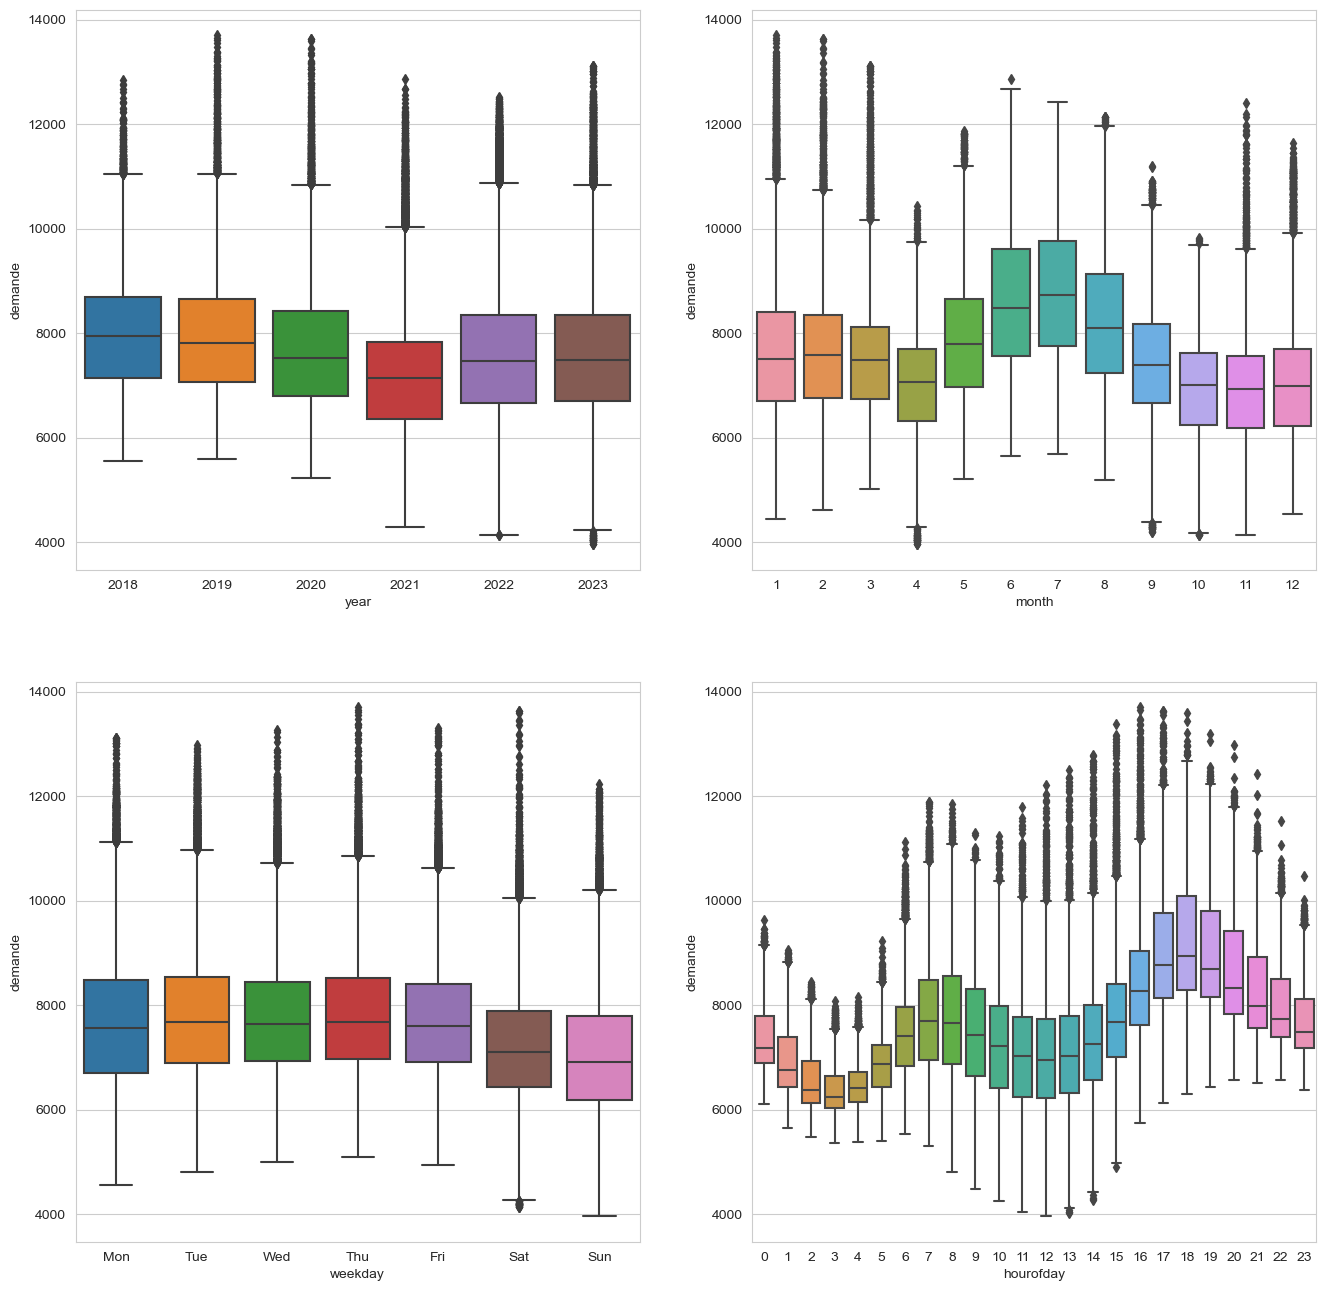

In [22]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16,16)
fig, axes = plt.subplots(2,2, figsize=(16, 16))
                        
#Model
#tableau_des_abscisses = ['', ''] #si on veut changer les valeur numeriques en valeur alphabetiques plus parlantes
#g = sns.boxplot(x = 'colonne_abscisse', y = 'colonne_ordonnee', data = df, ax=axes[i][j]) #la figure sera dessinnee en position i,j
#g.set_xticklabels(tableau_des_abscisses) #on change les valeurs numeriques en valeurs alphabetiques si on le souhaite

year_labels = range(2018, 2024)
g = sns.boxplot(x = 'year', y = 'demande', data = df, ax=axes[0][0])
g.set_xticklabels(year_labels)

g = sns.boxplot(x = 'month', y = 'demande', data = df, ax=axes[0][1])

dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x = 'weekday', y = 'demande', data = df, ax=axes[1][0])
g.set_xticklabels(dow_labels)

g = sns.boxplot(x = 'hourofday', y = 'demande', data = df, ax=axes[1][1])

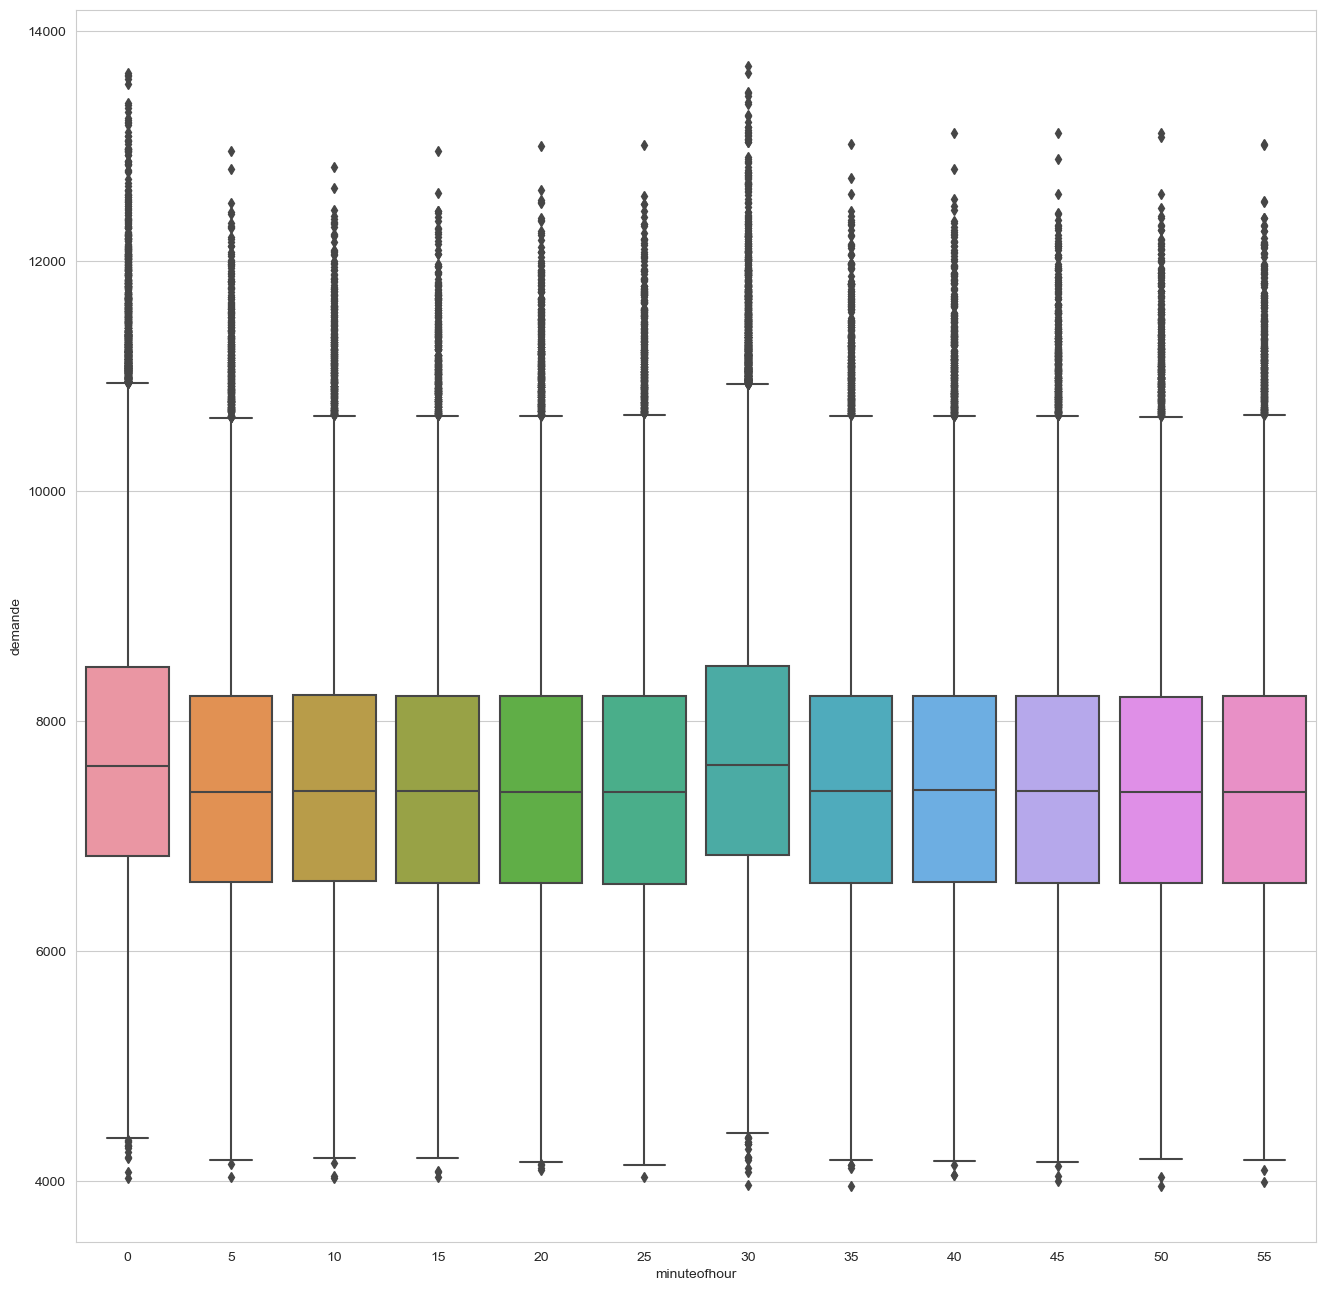

In [23]:
g = sns.boxplot(x = 'minuteofhour', y = 'demande', data = df)

## Seasonality, Trend, Noise decombosition

Compréhension des données :

Fréquence des données : Déterminez la fréquence de vos données. Par exemple, si vos données sont horodatées toutes les heures, alors la fréquence est horaire.
Période saisonnière : Identifiez la durée d'un cycle saisonnier que vous souhaitez analyser. Par exemple, pour des données horaires, une saisonnalité quotidienne aurait une période de 24 (heures).

Données horaires :
    Saison journalière : Période = 24 (heures)
    Saison hebdomadaire : Période = 24 * 7 (heures par semaine)
    Saison annuelle : Période = 24 * 365 (heures par année)
Données journalières :
    Saison hebdomadaire : Période = 7 (jours)
    Saison mensuelle : Période = 30 (jours)
    Saison annuelle : Période = 365 (jours)
Données mensuelles :
    Saison annuelle : Période = 12 (mois par année)

date
2018-01-01 00:30:00    1.102868
2018-01-01 01:00:00    1.094946
2018-01-01 01:30:00    1.083829
2018-01-01 02:00:00    1.072558
2018-01-01 02:30:00    1.066140
Name: seasonal, dtype: float64
date
2018-01-01 00:30:00    779.486706
2018-01-01 01:00:00    720.174198
2018-01-01 01:30:00    633.375959
2018-01-01 02:00:00    546.039605
2018-01-01 02:30:00    498.933437
Name: seasonal, dtype: float64


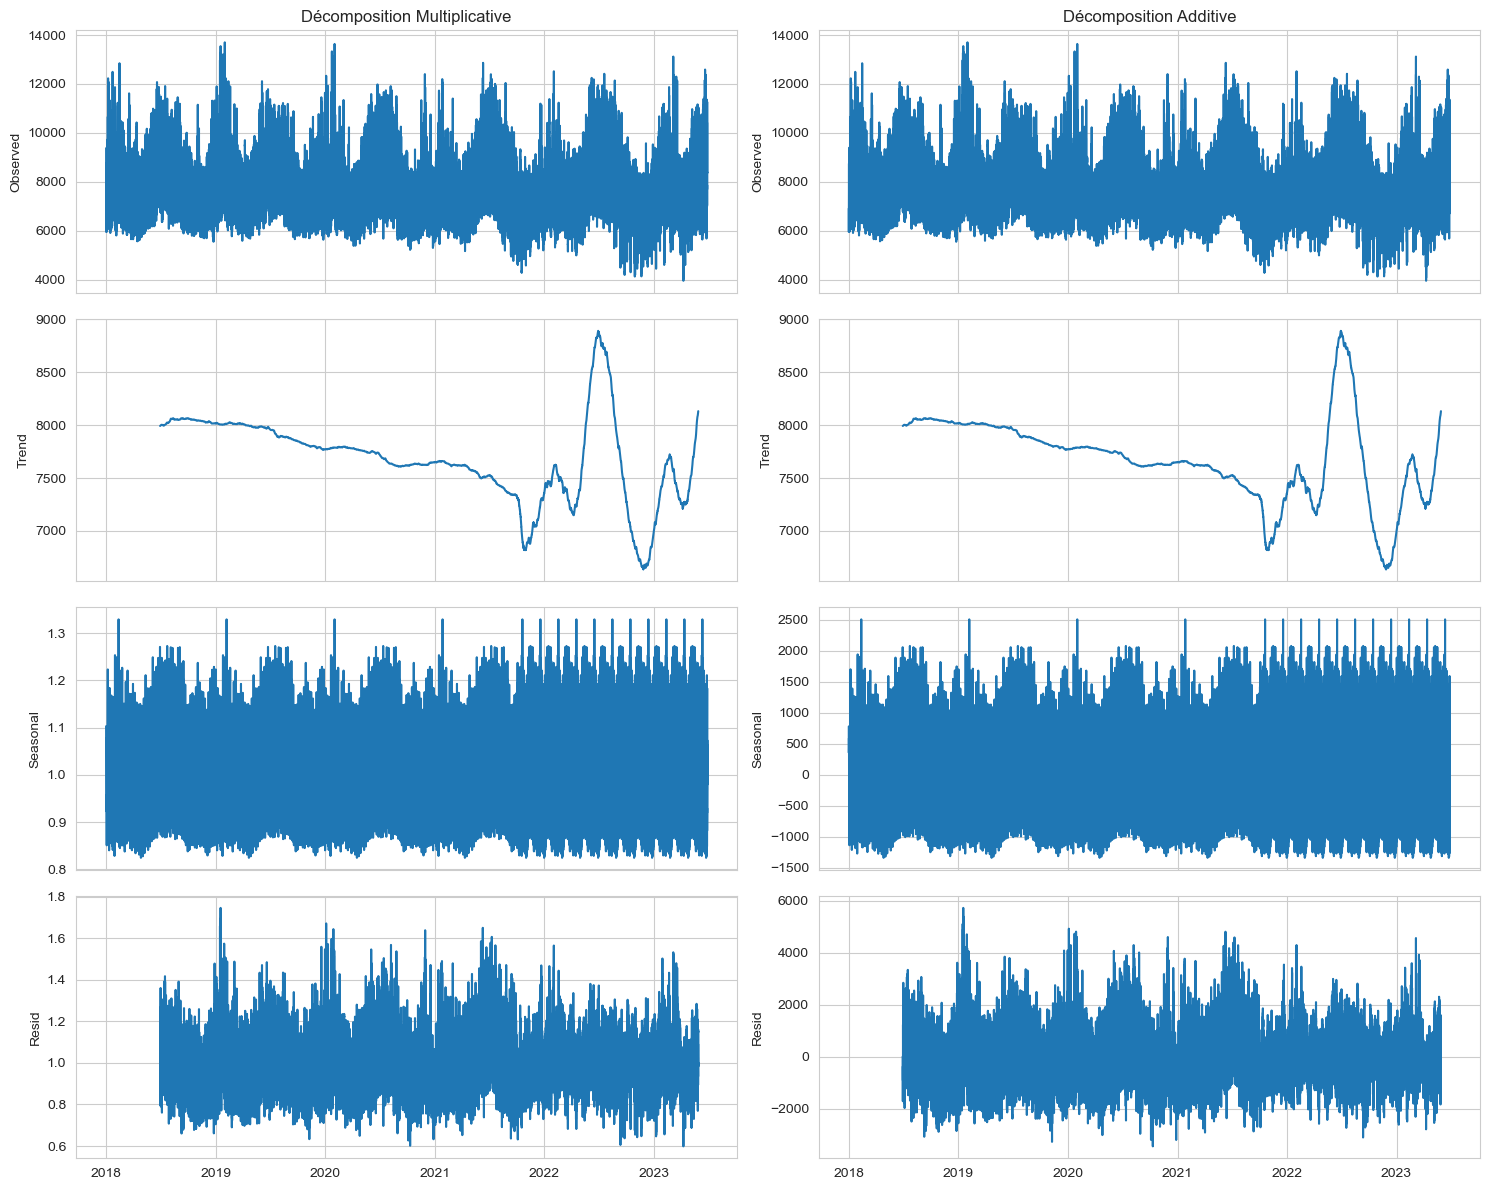

In [24]:
# Définir la période pour la décomposition saisonnière
periode = 12*30*24*2 #ici le donnees sont enregistre au max toutes les 30 minutes et on choisit l'annee comme periode
#periode = 30*24*2 #ici le donnees sont enregistre au max toutes les 30 minutes et on choisit le mois comme periode

# Décomposition multiplicative
decomp_multi = sm.tsa.seasonal_decompose(df['demande'], model='multiplicative', period=periode)
print(decomp_multi.seasonal.head())  # Vérification de la composante saisonnière

# Décomposition additive
decomp_addi = sm.tsa.seasonal_decompose(df['demande'], model='additive', period=periode)
print(decomp_addi.seasonal.head())  # Vérification de la composante saisonnière

# Affichage des résultats de la décomposition
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']

# Affichage de la décomposition multiplicative
for i, comp in enumerate(components):
    axes[i, 0].plot(getattr(decomp_multi, comp))
    axes[i, 0].set_ylabel(comp.capitalize())
axes[0, 0].set_title('Décomposition Multiplicative')

# Affichage de la décomposition additive
for i, comp in enumerate(components):
    axes[i, 1].plot(getattr(decomp_addi, comp))
    axes[i, 1].set_ylabel(comp.capitalize())
axes[0, 1].set_title('Décomposition Additive')

plt.tight_layout()
plt.show()

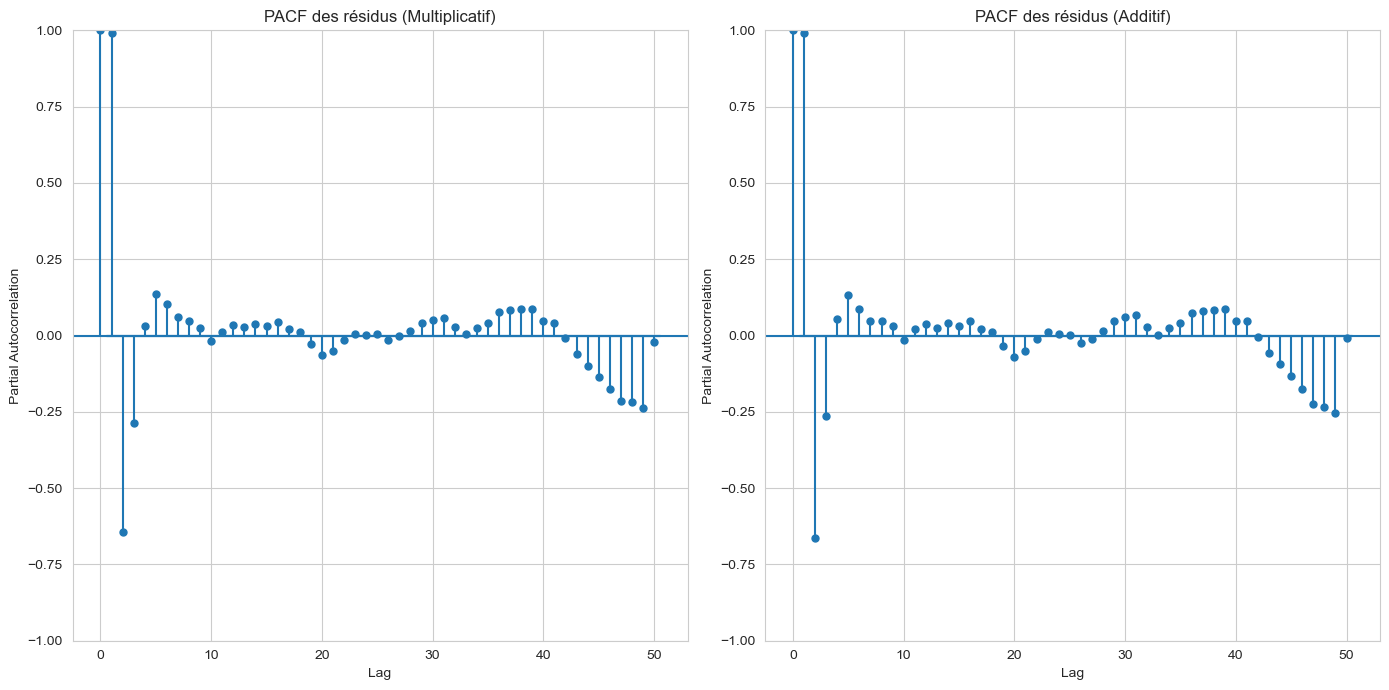

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

# Extraction des résidus
resid_multi = decomp_multi.resid.dropna()
resid_addi = decomp_addi.resid.dropna()

# Création d'une figure avec deux sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Calcul et affichage de la PACF pour les résidus de la décomposition multiplicative
plot_pacf(resid_multi, lags=50, ax=axes[0], title='PACF des résidus (Multiplicatif)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Partial Autocorrelation')
axes[0].grid(True)

# Calcul et affichage de la PACF pour les résidus de la décomposition additive
plot_pacf(resid_addi, lags=50, ax=axes[1], title='PACF des résidus (Additif)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Separation des datas en train et test

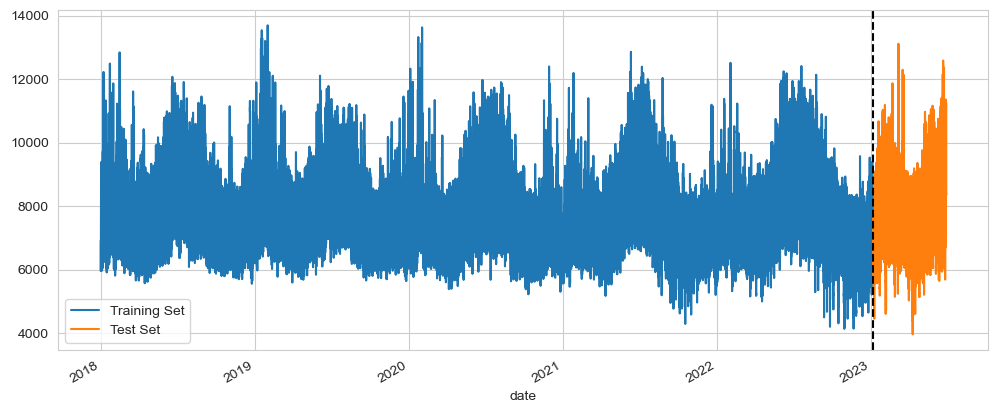

In [26]:
# Calculer l'indice de division
split_index = int(len(df) * 0.8)

train = df[:split_index]
test = df[split_index:]

fig, ax = plt.subplots(figsize=(12,5))
train["demande"].plot(ax=ax, label="Training Set")
test["demande"].plot(ax=ax, label="Test Set")
ax.axvline(pd.to_datetime(df.index[split_index]), color="black", ls="--")
ax.legend(["Training Set","Test Set"])
plt.show()

### Normalisation des donnees

## Feature Correlation

In [27]:
# df.corr(method='spearman')
df.corr(method='pearson')

,demande,prix,minuteofhour,quarter,Time,hourofday,dayofweek,weekday,dayofmonth,dayofyear,weekofyear,month,year,holidays
demande,1.000000,0.232052,-3.813559e-02,-0.165032,0.449944,4.519611e-01,-0.169776,-0.169776,0.025304,-0.146408,-0.152838,-0.148314,-0.071891,-0.020584
prix,0.232052,1.000000,3.649699e-02,-0.014743,0.062396,6.090735e-02,-0.032587,-0.032587,-0.002560,-0.016822,-0.019301,-0.015786,0.095896,0.012190
minuteofhour,-0.038136,0.036497,1.000000e+00,0.003899,0.042288,-1.146996e-15,0.000406,0.000406,-0.001302,0.003302,0.002838,0.003660,0.263264,0.001265
quarter,-0.165032,-0.014743,3.899038e-03,1.000000,0.000159,-5.784387e-06,0.004084,0.004084,0.015515,0.970487,0.950181,0.973205,-0.232871,0.023522
Time,0.449944,0.062396,4.228779e-02,0.000159,1.000000,9.991055e-01,0.000010,0.000010,-0.000076,0.000129,0.000109,0.000145,0.011110,0.000092
hourofday,0.451961,0.060907,-1.146996e-15,-0.000006,0.999105,1.000000e+00,-0.000007,-0.000007,-0.000021,-0.000011,-0.000011,-0.000009,-0.000023,0.000039
dayofweek,-0.169776,-0.032587,4.059688e-04,0.004084,0.000010,-6.676522e-06,1.000000,1.000000,-0.003004,0.000797,0.002414,0.001047,0.000118,-0.042205
weekday,-0.169776,-0.032587,4.059688e-04,0.004084,0.000010,-6.676522e-06,1.000000,1.000000,-0.003004,0.000797,0.002414,0.001047,0.000118,-0.042205
dayofmonth,0.025304,-0.002560,-1.301733e-03,0.015515,-0.000076,-2.057443e-05,-0.003004,-0.003004,1.000000,0.093022,0.067773,0.012665,-0.009577,-0.089107
dayofyear,-0.146408,-0.016822,3.302418e-03,0.970487,0.000129,-1.093009e-05,0.000797,0.000797,0.093022,1.000000,0.974202,0.996740,-0.228061,0.009652


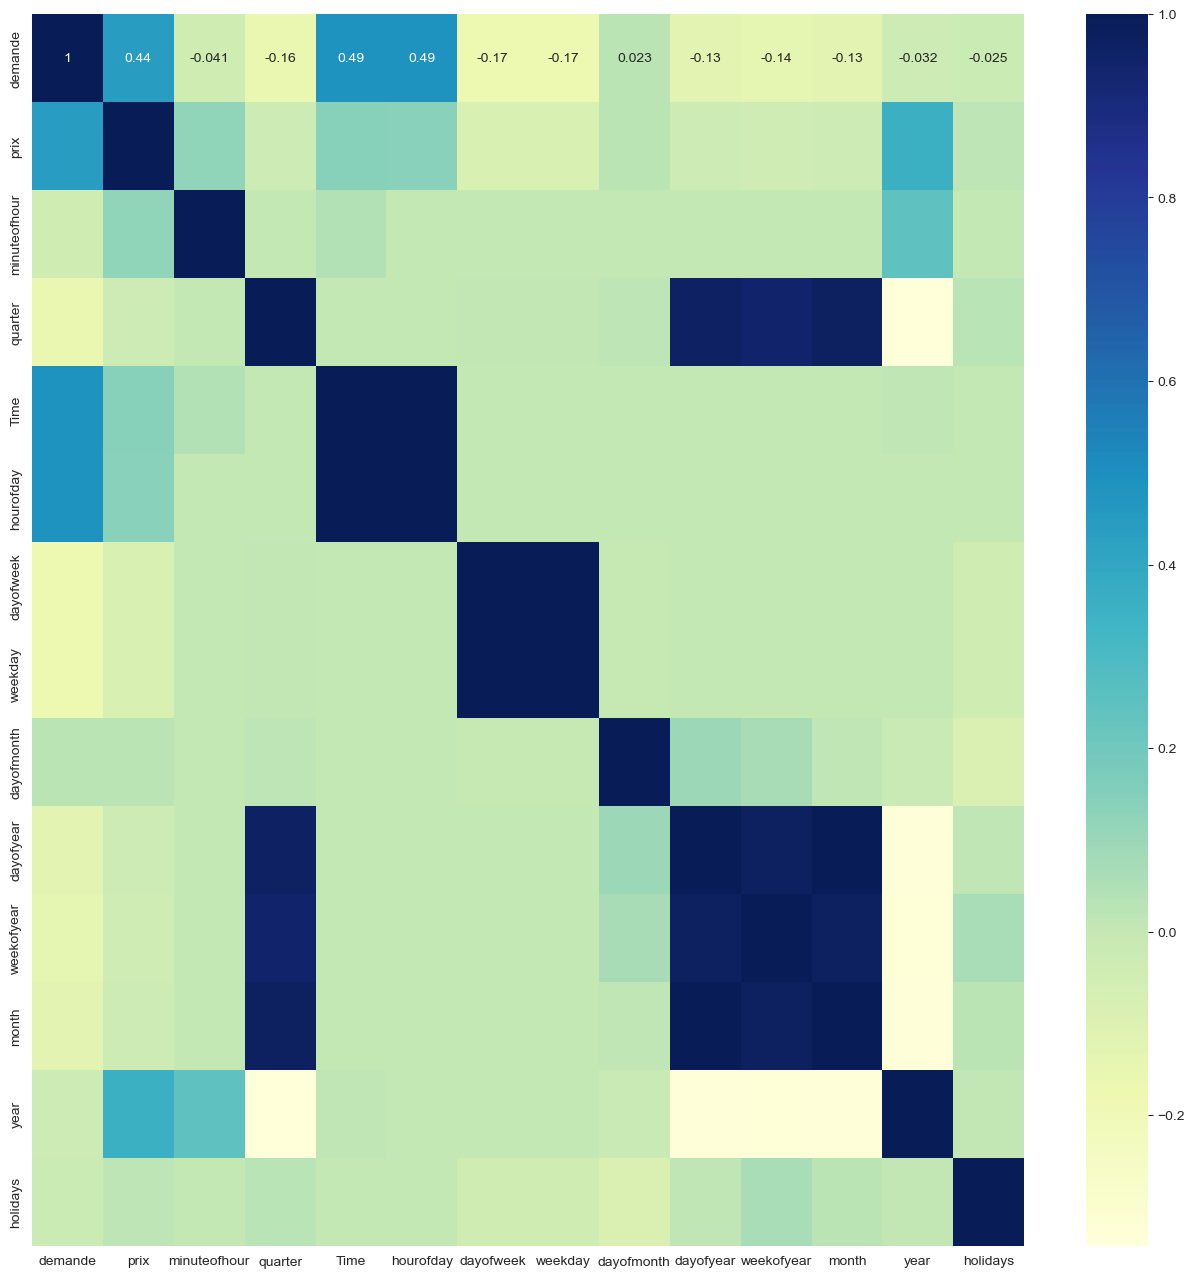

In [28]:
#corr_heatmap = sns.heatmap(df.drop('colonne_a_delete', axis=1).corr(method='spearman'), cmap="YlGnBu", annot=True)
corr_heatmap = sns.heatmap(df.corr(method='spearman'), cmap="YlGnBu", annot=True)

### Interprétation Globale des Résultats
SSR based F test : Ce test utilise la somme des résidus carrés (SSR) pour mesurer la proportion de la variance expliquée par les lags de la série temporelle candidate. La statistique F élevée et les p-values extrêmement faibles (0.0000) pour les lags de 1 et 2 indiquent que les lags de `feature` expliquent de manière significative la variation de `target`.
SSR based chi2 test : Ce test transforme la statistique F en une distribution chi-carré pour évaluer l'ajustement du modèle. Les p-values de 0.0000 pour les deux lags montrent que les lags de `feature` ont une influence significative sur `target`.
Likelihood ratio test : Ce test compare la vraisemblance des modèles avec et sans les lags de la série candidate. Les p-values de 0.0000 indiquent que les lags de `feature` ajoutent une valeur prédictive significative au modèle de `target`.
Parameter F test : Ce test est similaire au SSR based F test et vérifie les paramètres du modèle. Les p-values de 0.0000 confirment encore une fois la relation significative entre les lags de `feature` et `target`.

### Conclusion
Les résultats des tests de causalité de Granger montrent une relation de causalité significative entre `feature` et `target`. Les valeurs passées de `feature` sont utiles pour prédire les valeurs futures de `target`, comme indiqué par les p-values très faibles pour tous les tests et pour les lags de 1 et 2 périodes. Cela suggère que `feature` Granger-cause `target`, ce qui est essentiel pour la modélisation et la prévision des séries temporelles dans ce contexte. Plus p est faible plus la variable doit etre utilisee pour la prediction.

In [29]:
grangercausalitytests(train[['demande', 'prix']], maxlag=2)

target_colonne = 'demande'
max_lag = 1

list_colonne = df.columns

for i in list_colonne:
    if i != target_colonne:
        print(i)
        grangercausalitytests(train[[i, target_colonne]], maxlag=max_lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.1186 , p=0.0000  , df_denom=198869, df_num=1
ssr based chi2 test:   chi2=33.1191 , p=0.0000  , df=1
likelihood ratio test: chi2=33.1164 , p=0.0000  , df=1
parameter F test:         F=33.1186 , p=0.0000  , df_denom=198869, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=176.6237, p=0.0000  , df_denom=198866, df_num=2
ssr based chi2 test:   chi2=353.2563, p=0.0000  , df=2
likelihood ratio test: chi2=352.9429, p=0.0000  , df=2
parameter F test:         F=176.6237, p=0.0000  , df_denom=198866, df_num=2
prix

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3036.6031, p=0.0000  , df_denom=198869, df_num=1
ssr based chi2 test:   chi2=3036.6489, p=0.0000  , df=1
likelihood ratio test: chi2=3013.6984, p=0.0000  , df=1
parameter F test:         F=3036.6031, p=0.0000  , df_denom=198869, df_num=1
minuteofhour

Granger Causality
number of lags (no zero) 1
ssr base

### Maintenant a base des deux resultats precedents, on peut choisir les varialbles explicatives avec lequelles on veux faire la regression.

## Predictions

In [30]:
train.columns

Index(['demande', 'prix', 'minuteofhour', 'quarter', 'Time', 'hourofday',
       'dayofweek', 'weekday', 'dayofmonth', 'dayofyear', 'weekofyear',
       'month', 'year', 'holidays'],
      dtype='object')

In [31]:
# Création des variables explicatives et de la variable cible
feature = ['prix', 'minuteofhour', 'quarter', 'Time', 'hourofday', 'dayofweek', 'weekday', 'dayofmonth', 'dayofyear', 'weekofyear', 'month', 'year', 'holidays']
target = 'demande'

### Normalisation des donnees

In [32]:
# Fonction pour créer des séquences pour LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [33]:
x = df[feature]
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [34]:
# Normalisation des données pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[[target]])
seq_length = 10
x_lstm, y_lstm = create_sequences(scaled_data, seq_length)
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_lstm, y_lstm, test_size=0.2, random_state=42)

### Creation du model

In [35]:
# Paramètres du modèle
n_layers = 2            # Nombre de couches LSTM
n_cells = 50            # Nombre de cellules par couche LSTM
learning_rate = 0.001   # Taux d'apprentissage
batch_size = 32         # Taille du batch
activation_function = 'tanh'  # Fonction d'activation pour l'état de la cellule
recurrent_activation = 'sigmoid'  # Fonction d'activation pour les portes
loss_function = 'mean_squared_error'  # Fonction de perte
optimizer = Adam(learning_rate=learning_rate)  # Optimiseur

In [36]:
# Création du modèle LSTM
model_lstm = Sequential()

# Ajout des couches LSTM
for i in range(n_layers):
    if i == n_layers - 1:
        # Dernière couche LSTM sans retour de séquence
        model_lstm.add(LSTM(n_cells, activation=activation_function, recurrent_activation=recurrent_activation, return_sequences=False))
    else:
        # Couches LSTM intermédiaires avec retour de séquence
        model_lstm.add(LSTM(n_cells, activation=activation_function, recurrent_activation=recurrent_activation, return_sequences=True))

# Ajout d'une couche dense pour la sortie
model_lstm.add(Dense(len(feature)))

# Compilation du modèle
model_lstm.compile(optimizer=optimizer, loss=loss_function)

# Affichage du résumé du modèle
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrainement du model

In [37]:
# Enregistrer le temps de début
start_time = time.time()

model_lstm.fit(x_train_lstm, y_train_lstm, batch_size=1, epochs=10)

# Enregistrer le temps de fin
end_time = time.time()

Epoch 1/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 336s 2ms/step - loss: 4.1201e-04
Epoch 2/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 342s 2ms/step - loss: 8.2781e-05
Epoch 3/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 338s 2ms/step - loss: 7.5564e-05
Epoch 4/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 348s 2ms/step - loss: 7.2728e-05
Epoch 5/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 334s 2ms/step - loss: 6.9877e-05
Epoch 6/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 349s 2ms/step - loss: 6.8166e-05
Epoch 7/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 352s 2ms/step - loss: 6.6444e-05
Epoch 8/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 356s 2ms/step - loss: 6.5611e-05
Epoch 9/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 365s 2ms/step - loss: 6.4223e-05
Epoch 10/10
198865/198865 ━━━━━━━━━━━━━━━━━━━━ 340s 2ms/step - loss: 6.3232e-05


### Phase de prediction

In [38]:
# Prédictions
y_pred_lstm = model_lstm.predict(x_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


### Calcul et affichage de l'erreur

In [39]:
# Calcul de l'erreur quadratique moyenne
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
print("MSE LSTM:", mse_lstm)

# RSME LSTM
rmse_lstm = np.sqrt(mse_lstm)
print("RMSE LSTM:", rmse_lstm)

# Calculer la durée d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

ValueError: y_true and y_pred have different number of output (1!=13)

### Visualisation des resultats

In [ ]:
# Si la longueur de y_pred_lstm est différente de celle de test, ajustez les longueurs
if len(y_pred_lstm) > len(test):
    y_pred_lstm = y_pred_lstm[:len(test)]
elif len(y_pred_lstm) < len(test):
    # Si y_pred_lstm est plus court, il peut être nécessaire de tronquer test
    test = test.iloc[:len(y_pred_lstm)]

# Ajout de la prédiction au DataFrame test
test["prediction"] = y_pred_lstm

# Affichage des colonnes cibles et des prédictions
print(test[[target_colonne, "prediction"]])

                     demande   prediction
date                                     
2023-01-06 08:50:00  6887.52  6350.727051
2023-01-06 08:55:00  6851.01  6871.160156
2023-01-06 09:00:00  6860.00  6579.461426
2023-01-06 09:05:00  6902.02  9288.292969
2023-01-06 09:10:00  6962.24  8063.650879
...                      ...          ...
2023-06-27 23:30:00  8574.29  8214.590820
2023-06-27 23:35:00  8441.95  7358.610840
2023-06-27 23:40:00  8536.43  6457.856934
2023-06-27 23:45:00  8527.02  8032.920410
2023-06-27 23:50:00  8489.29  9123.688477

[49717 rows x 2 columns]


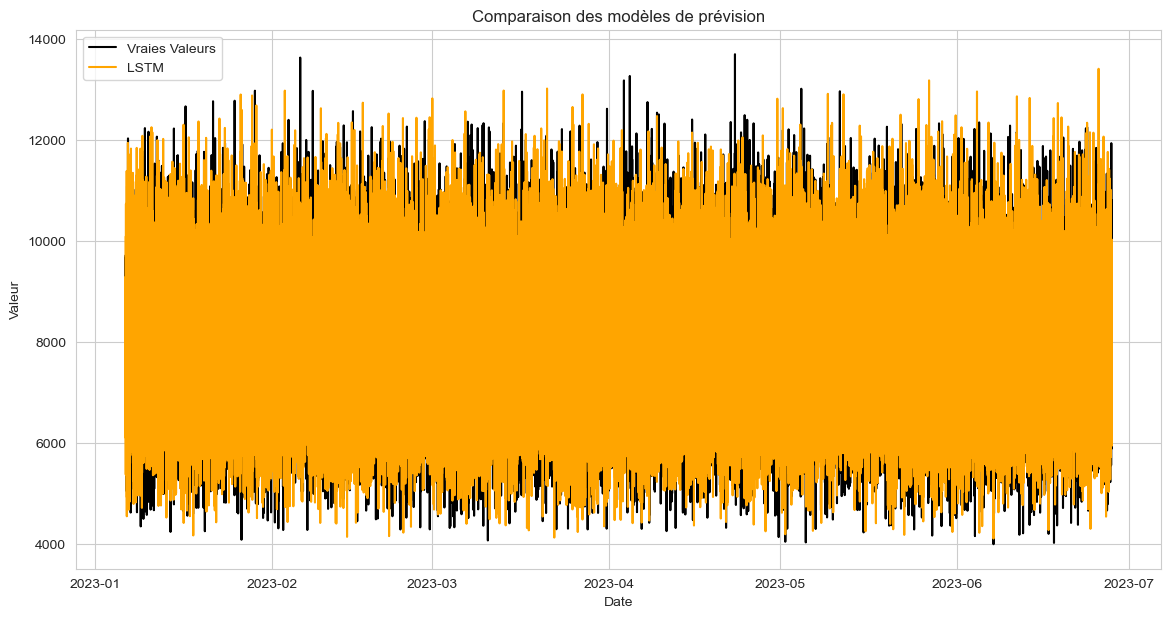

In [ ]:
# Assurez-vous que les dimensions de y_pred_lstm correspondent à y_test
if len(y_pred_lstm) > len(y_test):
    y_pred_lstm = y_pred_lstm[:len(y_test)]
elif len(y_pred_lstm) < len(y_test):
    y_test = y_test[:len(y_pred_lstm)]

# Visualisation des résultats pour toutes les données
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Vraies Valeurs', color='black')
plt.plot(test.index, y_pred_lstm, label='LSTM', color='orange')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

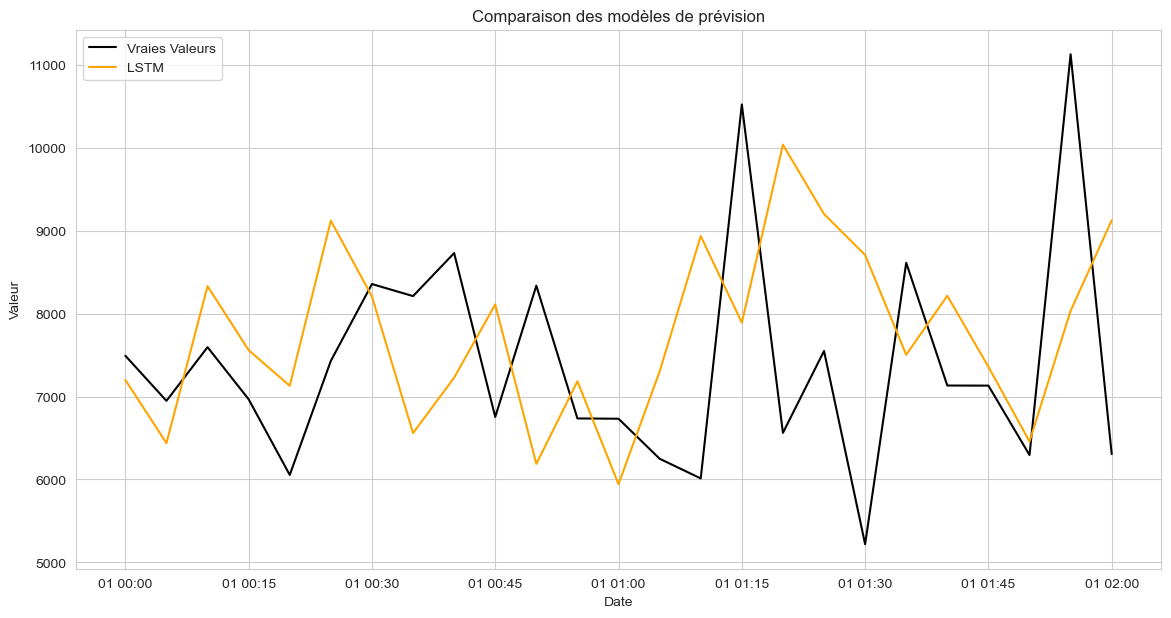

In [ ]:
# Définir les dates de début et de fin pour l'affichage
start_date = '2023-06-01 00'
end_date = '2023-06-01 02'

# Filtrer le DataFrame df pour n'inclure que les dates entre start_date et end_date
mask = (test.index >= start_date) & (test.index <= end_date)
filtered_df = test.index[mask]

# Récupérer les indices filtrés pour y_test et y_pred_lstm
filtered_y_test = y_test[mask]
filtered_y_pred_lstm = y_pred_lstm[-len(filtered_y_test):]

# S'assurer que les tailles correspondent
if len(filtered_y_pred_lstm) > len(filtered_y_test):
    filtered_y_pred_lstm = filtered_y_pred_lstm[:len(filtered_y_test)]
elif len(filtered_y_pred_lstm) < len(filtered_y_test):
    filtered_y_test = filtered_y_test[:len(filtered_y_pred_lstm)]

# Visualisation des résultats
plt.figure(figsize=(14, 7))
plt.plot(filtered_df, filtered_y_test, label='Vraies Valeurs', color='black')
plt.plot(filtered_df, filtered_y_pred_lstm, label='LSTM', color='orange')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()